In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
import cv2
from nltk.corpus import stopwords
import string
from tqdm import tqdm
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import collections

Using TensorFlow backend.
/home/rahul/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rahul/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rahul/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rahul/anaconda3/lib/python3.7/site-packages/tensorflo

In [2]:
#Read Text Captions
def readTextfile(path):
    with open(path) as f:
        captions=f.read()
    return captions

In [3]:
captions=readTextfile("./Flickr8k/Flickr8k_text/Flickr8k.token.txt")
captions=captions.split("\n")[:-1]

In [4]:
captions[-1]

'997722733_0cb5439472.jpg#4\tA rock climber practices on a rock climbing wall .'

In [5]:
first,second=captions[-1].split('\t')
first=first.split('.')[0]
second=second.split('.')[0]
print(first,second)

997722733_0cb5439472 A rock climber practices on a rock climbing wall 


In [6]:
#Dictionary to map each image with its given captions [0-4]
descriptions={}
for x in captions:
    first,second=x.split('\t')
    img_name=first.split('.')[0]
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[]
    descriptions[img_name].append(second)

In [7]:
descriptions['997722733_0cb5439472']

['A man in a pink shirt climbs a rock face',
 'A man is rock climbing high in the air .',
 'A person in a red shirt climbing up a rock face covered in assist handles .',
 'A rock climber in a red shirt .',
 'A rock climber practices on a rock climbing wall .']

In [8]:
img_path="./Flickr8k/Flickr8k_Dataset/Flicker8k_Dataset/"
img=cv2.imread(img_path+'997722733_0cb5439472.jpg')

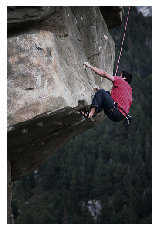

In [9]:
img =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

## Data Cleaning

In [10]:
#we will not remove stopwords eg:about,itself etc.
#we dont perform stemming eg:playying,plays-->'play'
def clean_sentences(sentense):
    sentense=sentense.lower()
    sentense=re.sub("[^a-z]+"," ",sentense)
    sentense=sentense.split()
    sentense=[s for s in sentense if len(s)>1]
    sentense=" ".join(sentense)
    return sentense

In [11]:
clean_sentences("Xy &hsu and ((823))")

'xy hsu and'

In [12]:
for key,captions in descriptions.items():
    for i in range(len(captions)):
        captions[i]=clean_sentences(captions[i])

In [13]:
descriptions['997722733_0cb5439472']

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [14]:
#Write the data to text file
with open('descriptions.txt','w') as f:
    f.write(str(descriptions))

## Vocabulary

In [15]:
descriptions = None
with open('descriptions.txt','r') as f:
    descriptions=f.read()
json_acceptable_string=descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [16]:
print(type(descriptions))

<class 'dict'>


In [17]:
descriptions['997722733_0cb5439472']

['man in pink shirt climbs rock face',
 'man is rock climbing high in the air',
 'person in red shirt climbing up rock face covered in assist handles',
 'rock climber in red shirt',
 'rock climber practices on rock climbing wall']

In [18]:
#vocab
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentense.split()) for sentense in descriptions[key]]
print("Vocab Size: %d"%len(vocab))#unique words

Vocab Size: 8424


In [19]:
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print('total words:',len(total_words))
    

total words: 373837


In [20]:
#Filter words from vocab according to their frequency /threshold
counter = collections.Counter(total_words)
freq_count = dict(counter)

In [21]:
#sort this dictionary acc to count
sorted_freq_count=sorted(freq_count.items(),reverse=True,key=lambda x:x[1])

#filter
threshold=10
sorted_freq_count=[x for x in sorted_freq_count if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_count]

In [22]:
total_words[:10]#top 10 frequent words

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two']

In [23]:
print(len(total_words))

1845


## Prepare Train/Test Data

In [24]:
train_file_data=readTextfile("./Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data=readTextfile("./Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt")

In [25]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(len(train))
print(len(test))

6000
1000


In [26]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [27]:
#Prepare Descriptions for the training data
#Tweak <s> and <e> token to training data
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append='startseq ' + cap + ' endseq'
        train_descriptions[img_id].append(cap_to_append)

## Transfer Learning
>Images-->Features

>Text-->Features

In [28]:
model=ResNet50(weights='imagenet',input_shape=(224,224,3))

In [29]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [30]:
model.layers[-2]

In [31]:
model=Model(model.input,model.layers[-2].output)

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [33]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)#convert img into 4D tensor
    #Normalisation
    img=preprocess_input(img)
    return img

In [34]:
img = preprocess_img(img_path+'997722733_0cb5439472.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


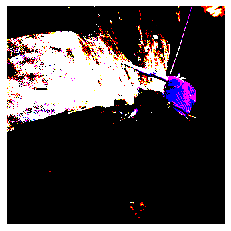

In [35]:
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [36]:
def encode_img(img):
    img=preprocess_img(img)
    feature_vector = model.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
#     print(feature_vector.shape)
    return feature_vector

In [37]:
encode_img(img_path+'997722733_0cb5439472.jpg')

array([0.66421807, 0.12799257, 0.        , ..., 0.19685948, 0.29330796,
       0.13050742], dtype=float32)

In [38]:
start_time=time()
encoding_train={}

#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img=img_path+ "/" + img_id + '.jpg'
    encoding_train[img[len(img_path):]]=encode_img(img)
    if ix%100==0:
        print('Encoding in Progress Time Step %d'%ix)
end_time=time()
print('totaltime',end_time-start_time)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
Encoding in Progress Time Step 1000
Encoding in Progress Time Step 1100
Encoding in Progress Time Step 1200
Encoding in Progress Time Step 1300
Encoding in Progress Time Step 1400
Encoding in Progress Time Step 1500
Encoding in Progress Time Step 1600
Encoding in Progress Time Step 1700
Encoding in Progress Time Step 1800
Encoding in Progress Time Step 1900
Encoding in Progress Time Step 2000
Encoding in Progress Time Step 2100
Encoding in Progress Time Step 2200
Encoding in Progress Time Step 2300
Encoding in Progress Time Step 2400
Encoding in Progress Time Step 2500
Encoding in Progress Time Step 2600
Encoding in Progress Time Step 2700
Enco

In [39]:
#Store Everything to the disk

with open('encoded_train_features.pkl','wb') as f:
    pickle.dump(encoding_train,f)

# with open('encoded_train_images.pkl','rb') as f:#We have already stored so load it.
#     encoding_train= pickle.load(f)

In [40]:
start_time=time()
encoding_test={}

#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img=img_path+ "/" + img_id + '.jpg'
    encoding_test[img[len(img_path):]]=encode_img(img)
    if ix%100==0:
        print('Encoding in Progress Time Step %d'%ix)
end_time=time()
print('totaltime',end_time-start_time)

Encoding in Progress Time Step 0
Encoding in Progress Time Step 100
Encoding in Progress Time Step 200
Encoding in Progress Time Step 300
Encoding in Progress Time Step 400
Encoding in Progress Time Step 500
Encoding in Progress Time Step 600
Encoding in Progress Time Step 700
Encoding in Progress Time Step 800
Encoding in Progress Time Step 900
totaltime 127.22725749015808


In [41]:
with open('encoded_test_features.pkl','wb') as f:
    pickle.dump(encoding_test,f)
# with open('encoded_test_features.pkl','rb') as f:#We have already stored so load it.
#     encoding_test= pickle.load(f)

# Image Captioning
##### Generating Captions for Images

In [42]:
len(total_words)

1845

In [43]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word

In [44]:
word_to_idx

{'in': 1,
 'the': 2,
 'on': 3,
 'is': 4,
 'and': 5,
 'dog': 6,
 'with': 7,
 'man': 8,
 'of': 9,
 'two': 10,
 'white': 11,
 'black': 12,
 'boy': 13,
 'are': 14,
 'woman': 15,
 'girl': 16,
 'to': 17,
 'wearing': 18,
 'at': 19,
 'people': 20,
 'water': 21,
 'red': 22,
 'young': 23,
 'brown': 24,
 'an': 25,
 'his': 26,
 'blue': 27,
 'dogs': 28,
 'running': 29,
 'through': 30,
 'playing': 31,
 'while': 32,
 'shirt': 33,
 'down': 34,
 'standing': 35,
 'ball': 36,
 'little': 37,
 'grass': 38,
 'snow': 39,
 'child': 40,
 'person': 41,
 'jumping': 42,
 'over': 43,
 'three': 44,
 'front': 45,
 'sitting': 46,
 'holding': 47,
 'up': 48,
 'field': 49,
 'small': 50,
 'by': 51,
 'large': 52,
 'green': 53,
 'one': 54,
 'group': 55,
 'yellow': 56,
 'her': 57,
 'walking': 58,
 'children': 59,
 'men': 60,
 'into': 61,
 'air': 62,
 'beach': 63,
 'near': 64,
 'mouth': 65,
 'jumps': 66,
 'another': 67,
 'for': 68,
 'street': 69,
 'runs': 70,
 'its': 71,
 'from': 72,
 'riding': 73,
 'stands': 74,
 'as': 75,


In [45]:
print(len(word_to_idx))

1845


In [46]:
#add startseq and endseq that we have used in our created vocab

idx_to_word[1846]='startseq'
word_to_idx['startseq']=1846

idx_to_word[1847]='endseq'
word_to_idx['endseq']=1847

In [47]:
idx_to_word[1847]

'endseq'

In [48]:
vocab_size=len(idx_to_word)+1
print(vocab_size)

1848


In [49]:
max_len=0
for key in train_descriptions.keys():
    for captions in train_descriptions[key]:
        max_len=max(max_len,len(captions.split()))

In [50]:
print(max_len)

35


# Data Loader(Generator)


In [71]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train['/'+key+'.jpg']

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==batch_size:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

# Word Embeddings

In [52]:
f = open('glove.6B.50d.txt',encoding='utf8')

In [53]:
embedding_idx ={}

for line in f:
    value = line.split()
    word =value[0]
    word_embedding = np.asarray(value[1:],dtype='float')
    embedding_idx[word]=word_embedding

In [54]:
f.close()

In [55]:
embedding_idx['rahul']

array([-0.33427 , -0.71831 ,  0.23508 ,  0.816   ,  0.90321 ,  0.20248 ,
        1.1754  ,  0.06973 , -0.023236,  0.3165  ,  0.3398  ,  1.5831  ,
       -1.1176  ,  1.2782  , -0.22172 ,  0.33129 , -0.30211 ,  0.23153 ,
       -0.6184  , -0.13675 ,  0.24821 ,  1.6446  ,  0.19205 ,  0.084662,
        1.9944  , -0.46075 ,  0.28779 , -1.11    , -1.1892  ,  0.64099 ,
        0.31185 ,  0.31061 ,  0.38759 ,  1.6248  ,  0.73716 , -0.1432  ,
        0.48383 ,  0.45903 , -0.2289  ,  0.36481 , -0.4113  ,  1.1768  ,
        0.025607,  0.88886 , -1.0163  ,  1.3335  , -0.088277, -0.73858 ,
        0.80092 , -1.0685  ])

In [56]:
def get_embedmatrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in tqdm(word_to_idx.items()):
        embedding_vector = embedding_idx.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix

In [57]:
embedding_matrix = get_embedmatrix()
embedding_matrix.shape

100%|██████████| 1847/1847 [00:00<00:00, 175905.53it/s]


(1848, 50)

In [58]:
embedding_matrix[1845]

array([-0.34126 , -0.06117 ,  0.93339 , -0.48938 , -0.16882 ,  0.76947 ,
        0.11972 , -0.11674 , -0.54492 , -0.44433 , -0.44316 , -0.10517 ,
       -0.086709,  0.13392 , -1.0489  , -0.10756 ,  0.4921  ,  0.62526 ,
       -1.5142  , -0.88477 ,  0.28845 ,  0.26258 ,  0.10793 , -0.92586 ,
       -0.043537, -0.67035 ,  0.22245 ,  0.28499 ,  0.32135 , -0.22713 ,
        1.0602  , -0.89463 , -0.14558 , -0.041262,  0.19645 ,  0.65909 ,
        0.85064 , -0.34087 ,  0.19177 ,  0.49908 ,  1.0036  ,  0.70362 ,
       -0.41316 , -0.47519 ,  0.94353 ,  0.14839 , -0.42612 , -0.5682  ,
       -0.6244  ,  0.30874 ])

# Model Architecture

In [59]:
#Images to feature vector
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense (256,activation='relu') (inp_img1)

In [60]:
# Captions to Feature vector
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [61]:
decoder1  = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

#Combined Model
model =Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [62]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [63]:
#important thing :We will use our trained weights 
model.layers[2].set_weights([embedding_matrix])#Caption_weights
model.layers[2].trainable=False

In [64]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

In [65]:
epochs = 30 
batch_size = 3
step = len(train_descriptions)//batch_size

In [141]:
# for i in range(epochs):
#     generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len,batch_size)
#     model.fit_generator(generator, epochs=1, steps_per_epoch=step, verbose=1)
#     model.save('./model_weights/model_' + str(i) + '.h5')

In [142]:
model.load_weights('./model_weights/model_9.h5') #load the saved weights

In [143]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding= 'post')
        
        ypred =model.predict([photo,sequence])
        
        ypred = ypred.argmax()#choose words with max probablity
        
        word =idx_to_word[ypred]
        
        if word  == "endseq":
            break
        in_text += (' ' + word)
        
    final_caption  = in_text.split()[1:]
    final_caption  = ' '.join(final_caption)
        
    return final_caption

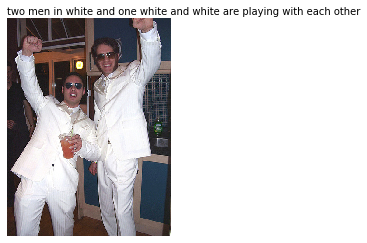

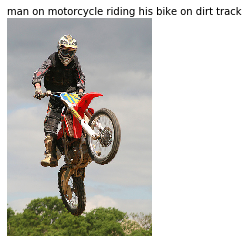

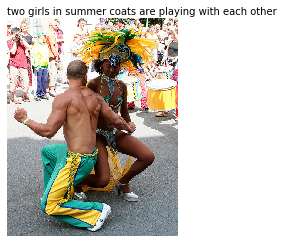

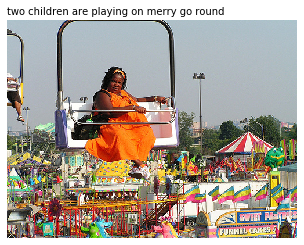

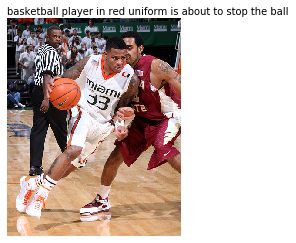

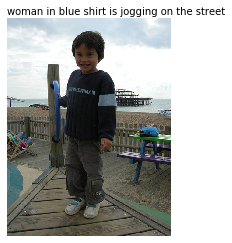

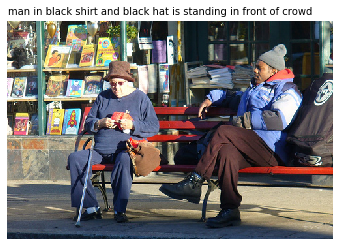

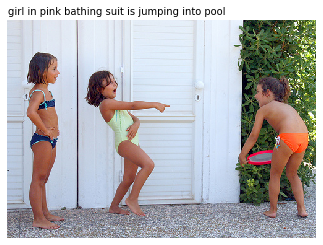

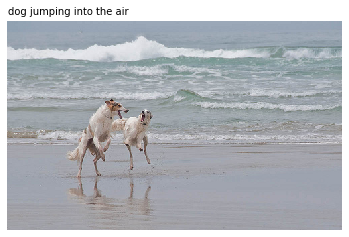

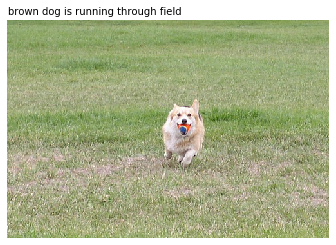

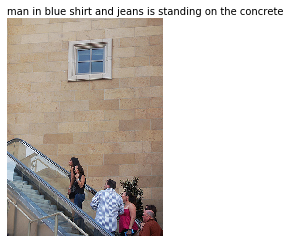

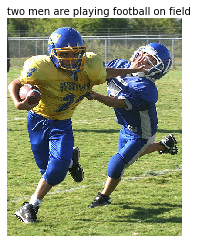

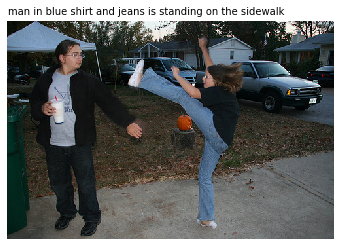

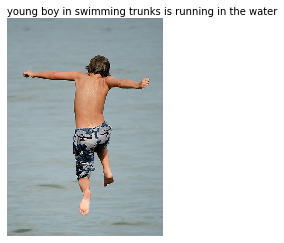

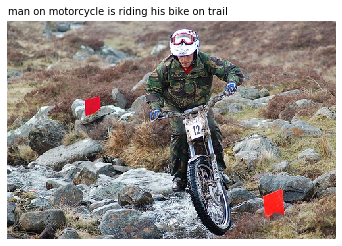

In [177]:
#Pick some random Images
for i in range(15):
    idx =np.random.randint(1000)
    all_img_name = list(encoding_test.keys())
    img =all_img_name[idx]
    
    photo_2048 =encoding_test[img].reshape((1,2048))
    i=plt.imread(img_path+img)
    caption = predict_caption(photo_2048)
    plt.axis('off')
    plt.imshow(i)
    plt.text(0,-10,caption)
    plt.show()